In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
init_df = pd.read_csv('../datasets/blog_authorship_tokenized.csv', usecols=['text', 'tokenized', 'n_words', 'gender'])
init_df.sample(15)

,text,gender,n_words,tokenized
455155,"Well, it looks like I wonât be posting anyt...",male,128,"well , it looks like i wonât be posting an..."
22241,Yay! Josh and I are all better I think. But I ...,female,103,yay ! josh and i are all better i think . but ...
584138,Classmates.com I'm totally addicted to this we...,male,691,classmates.com i 'm totally addicted to this w...
402020,I got Gmail and I'm going crazy! A conversatio...,male,502,i got gmail and i 'm going crazy ! a conversat...
355104,You Are A Perfect Date! Your manners are alway...,female,65,you are a perfect date ! your manners are alwa...
338578,"Ugh, I dragged myself to work today and manage...",female,218,"ugh , i dragged myself to work today and manag..."
325687,I was just thinking today about a nap. I asked...,male,196,i was just thinking today about a nap . i aske...
418537,Finally..i can breathe a huge sigh of relief.....,male,97,finally .. i can breathe a huge sigh of relief...
594198,Funniest thing happened driving from the schoo...,female,199,funniest thing happened driving from the schoo...
509290,Fun Junk Read his blog its soo random its gre...,female,20,fun junk read his blog its soo random its gr...


In [3]:
init_df.isnull().sum()

text         0
gender       0
n_words      0
tokenized    0
dtype: int64

In [4]:
# Stratify the sample by age group
df = init_df.groupby('gender', group_keys=False).apply(lambda x: x.sample(frac=.05))
df.shape

(31780, 4)

In [5]:
df['gender'].value_counts()

male      16118
female    15662
Name: gender, dtype: int64

In [6]:
enc = LabelEncoder()
enc.fit(df['gender'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
df['gender'] = enc.transform(df['gender'])
encoded_labels

{'female': 0, 'male': 1}

## On initial data

In [7]:
X = df[['text']]
y = df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=123, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25424, 1), (6356, 1), (25424,), (6356,))

In [8]:
ch_2grams_cv = CountVectorizer(analyzer='char', ngram_range=(2, 2), max_features=4000, stop_words=None)
ch_3grams_cv = CountVectorizer(analyzer='char', ngram_range=(3, 3), max_features=4000, stop_words=None)
wd_2grams_cv = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=4000, stop_words=None)
wd_3grams_cv = CountVectorizer(analyzer='word', ngram_range=(2, 2), max_features=4000, stop_words=None)
scl = MinMaxScaler()

ct = ColumnTransformer([
    ('vect_ch_2', ch_2grams_cv, 'text'),
    ('vect_ch_3', ch_3grams_cv, 'text'),
    # ('vect_wd_2', wd_2grams_cv, 'text'),
    ('vect_wd_3', wd_3grams_cv, 'text'),
    # ('scaler', scl, 'n_words'),
], remainder='passthrough', n_jobs=-1)

svm = SVC(kernel='linear')
logreg = LogisticRegression(
        solver='liblinear',
        penalty='l2'
    )

pipe = make_pipeline(ct, logreg)

In [9]:
param_grid = {
    'logisticregression__C': [1, 10],
    'logisticregression__max_iter': [5000, 2500, 1000]
}

In [10]:
gs = GridSearchCV(pipe, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5, error_score='raise')

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
{'logisticregression__C': 1, 'logisticregression__max_iter': 5000}


In [11]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.60      0.60      3132
           1       0.62      0.63      0.62      3224

    accuracy                           0.61      6356
   macro avg       0.61      0.61      0.61      6356
weighted avg       0.61      0.61      0.61      6356



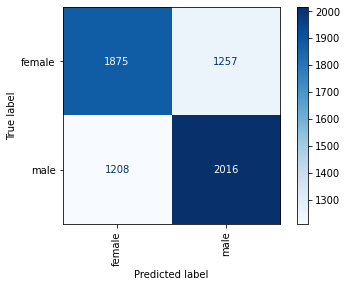

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = encoded_labels
disp.plot(cmap='Blues')
disp.ax_.tick_params(axis='x', rotation=90)
disp.ax_.set_facecolor('red');